In [113]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [114]:
 # Load the dataset
    
start_tok = '<S>'
end_tok = '<E>'
unk_tok = '<U>'
    
def load_dataset(file):
    reviews = open(file, 'r').read().splitlines()
    X = []
    Y = []
    for review in reviews:
        label, text = review.strip().split('|||')
        # Start and End tokens are added - in the final set, add space and unknown tokens as well
        X.append([ start_tok ] + text.strip().split(' ') + [ end_tok ])
        Y.append(int(label))
    return X, Y
        
Xtr, Ytr = load_dataset('data/sst-sentiment-text-threeclass/train.txt')
Xdev, Ydev = load_dataset('data/sst-sentiment-text-threeclass/dev.txt')
Xte, Yte = load_dataset('data/sst-sentiment-text-threeclass/test.txt')


In [115]:
import random
random.seed(42)

words = { word for x in Xtr for word in x }

stoi = {s:i+1 for i,s in enumerate(sorted(list(words)))}
stoi[unk_tok] = 0
itos = {i:s for s,i in stoi.items()}
wordset_size = len(itos)
print(wordset_size)



18283


In [116]:
readable_labels = {
    -1 : 'negative',
     0 : 'neutral',
     1 : 'positive'
}

readable_labels_size = len(readable_labels)

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return torch.eye(num_classes, dtype=torch.float32)[y]

itol = { i:v for i,v in enumerate(readable_labels) }
ltoi = { v:i for i,v in itol.items() }
itoc = { i:to_categorical(l, num_classes=readable_labels_size) for i,l in itol.items()}
def ctoi(t):
    for i,c in itoc.items():
        if torch.equal(c,t):
            return i
    return -1
itol, ltoi, itoc

({0: -1, 1: 0, 2: 1},
 {-1: 0, 0: 1, 1: 2},
 {0: tensor([0., 0., 1.]), 1: tensor([1., 0., 0.]), 2: tensor([0., 1., 0.])})

In [117]:
# build the dataset
block_size = 64

def build_dataset(X, Y):
    
    Xt, Yt = [], []
    stoi_keys = list(stoi.keys())
    
    for x,y in zip(X, Y):
        # padded context of zero tokens with block size expected
        context = [0] * block_size
        for i, w in enumerate(x):
            ix = stoi[w] if w in stoi_keys else 0
            if i > 1:
                Xt.append(context)
                Yt.append(itoc[ltoi[y]] if i > block_size // 4 else itoc[ltoi[0]])
            context = context[1:] + [ix] #crop and append
        
    Xt = torch.tensor(Xt)
    Yt = torch.stack(Yt)
    print(Xt.shape, Yt.shape)
    return Xt, Yt

 
Xtr, Ytr = build_dataset(Xtr, Ytr)      #80%
Xdev, Ydev = build_dataset(Xdev, Ydev)  #10%
Xte, Yte = build_dataset(Xte, Yte)      #10%


torch.Size([163563, 64]) torch.Size([163563, 3])
torch.Size([21274, 64]) torch.Size([21274, 3])
torch.Size([42405, 64]) torch.Size([42405, 3])


In [118]:
# Pick ten samples in intervals to show the construction of XTr train set and YTr label set
for x,y in zip(Xtr[::Xtr.shape[0]//10], Ytr[::Ytr.shape[0]//10]):
    print(' '.join(itos[ix.item()] for ix in x), '--->', readable_labels[itol[ctoi(y)]])

<U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <S> The ---> neutral
<U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <S> That old adage about women being unknowable gets an exhilarating ---> neutral
<U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <S> The main problem being ---> neutral
<U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <

In [119]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming initialization for normalized variance
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ---------------
class BatchNorm1d:
  def __init__(self, dim, eps=1e-6, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      dims = [d for d in range(0, x.dim() - 1)]
      xmean = x.mean(tuple(dims), keepdim=True) # batch mean
      xvar = x.var(tuple(dims), keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# ---------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# ---------------

class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
        
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
        
  def parameters(self):
    return [self.weight]

# ---------------
class FlattenConsecutive:
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# ---------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

# ---------------

class Softmax:
  def __call__(self, x):
    self.out = torch.softmax(x, dim=1)
    return self.out
  def parameters(self):
    return []

# ---------------

In [123]:
torch.manual_seed(42)
wordset_size

18283

In [129]:
n_embd = 10
n_hidden = 24

model = Sequential([
    Embedding(wordset_size, n_embd),
    FlattenConsecutive(4), Linear(n_embd * 4, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(4), Linear(n_hidden * 4, n_hidden // 2, bias=False), BatchNorm1d(n_hidden // 2), Tanh(),
    FlattenConsecutive(4), Linear(n_hidden *2, readable_labels_size)
])

    
#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 #last linear layer is reduced so that we make it less confident at the beginning
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

185161


In [130]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []
lossv = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.01 if i > max_steps/2 else 0.1

  for p in parameters:
    p.data += -lr * p.grad
    
  with torch.no_grad():
    ix = torch.randint(0, Xdev.shape[0], (batch_size,))
    Xv, Yv = Xdev[ix], Ydev[ix]
    vlogits = model(Xv)
    l = F.cross_entropy(vlogits, Yv)
    lossv.append(l.log10().item())

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: loss(test): {loss.item():.4f} :loss(val): {l.item():.4f} : lr:{lr:.3f}' )
    
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])



      0/ 100000: loss(test): 1.0821 :loss(val): 0.9223 : lr:0.100
  10000/ 100000: loss(test): 0.2881 :loss(val): 0.4058 : lr:0.100
  20000/ 100000: loss(test): 0.3438 :loss(val): 0.3113 : lr:0.100
  30000/ 100000: loss(test): 0.2327 :loss(val): 0.5508 : lr:0.100
  40000/ 100000: loss(test): 0.2383 :loss(val): 0.2681 : lr:0.100
  50000/ 100000: loss(test): 0.3570 :loss(val): 0.5273 : lr:0.100
  60000/ 100000: loss(test): 0.2141 :loss(val): 0.2139 : lr:0.010
  70000/ 100000: loss(test): 0.3049 :loss(val): 0.3550 : lr:0.010
  80000/ 100000: loss(test): 0.2909 :loss(val): 0.1014 : lr:0.010
  90000/ 100000: loss(test): 0.4214 :loss(val): 0.3848 : lr:0.010


In [131]:
for layer in model.layers:
    if layer.out != None:
      print(layer.__class__.__name__, ':', tuple(layer.out.shape))
    else:
      print(layer.__class__.__name__, ':', 'Uninitialized')

Embedding : (32, 64, 10)
FlattenConsecutive : (32, 16, 40)
Linear : (32, 16, 24)
BatchNorm1d : (32, 16, 24)
Tanh : (32, 16, 24)
FlattenConsecutive : (32, 4, 96)
Linear : (32, 4, 12)
BatchNorm1d : (32, 4, 12)
Tanh : (32, 4, 12)
FlattenConsecutive : (32, 48)
Linear : (32, 3)


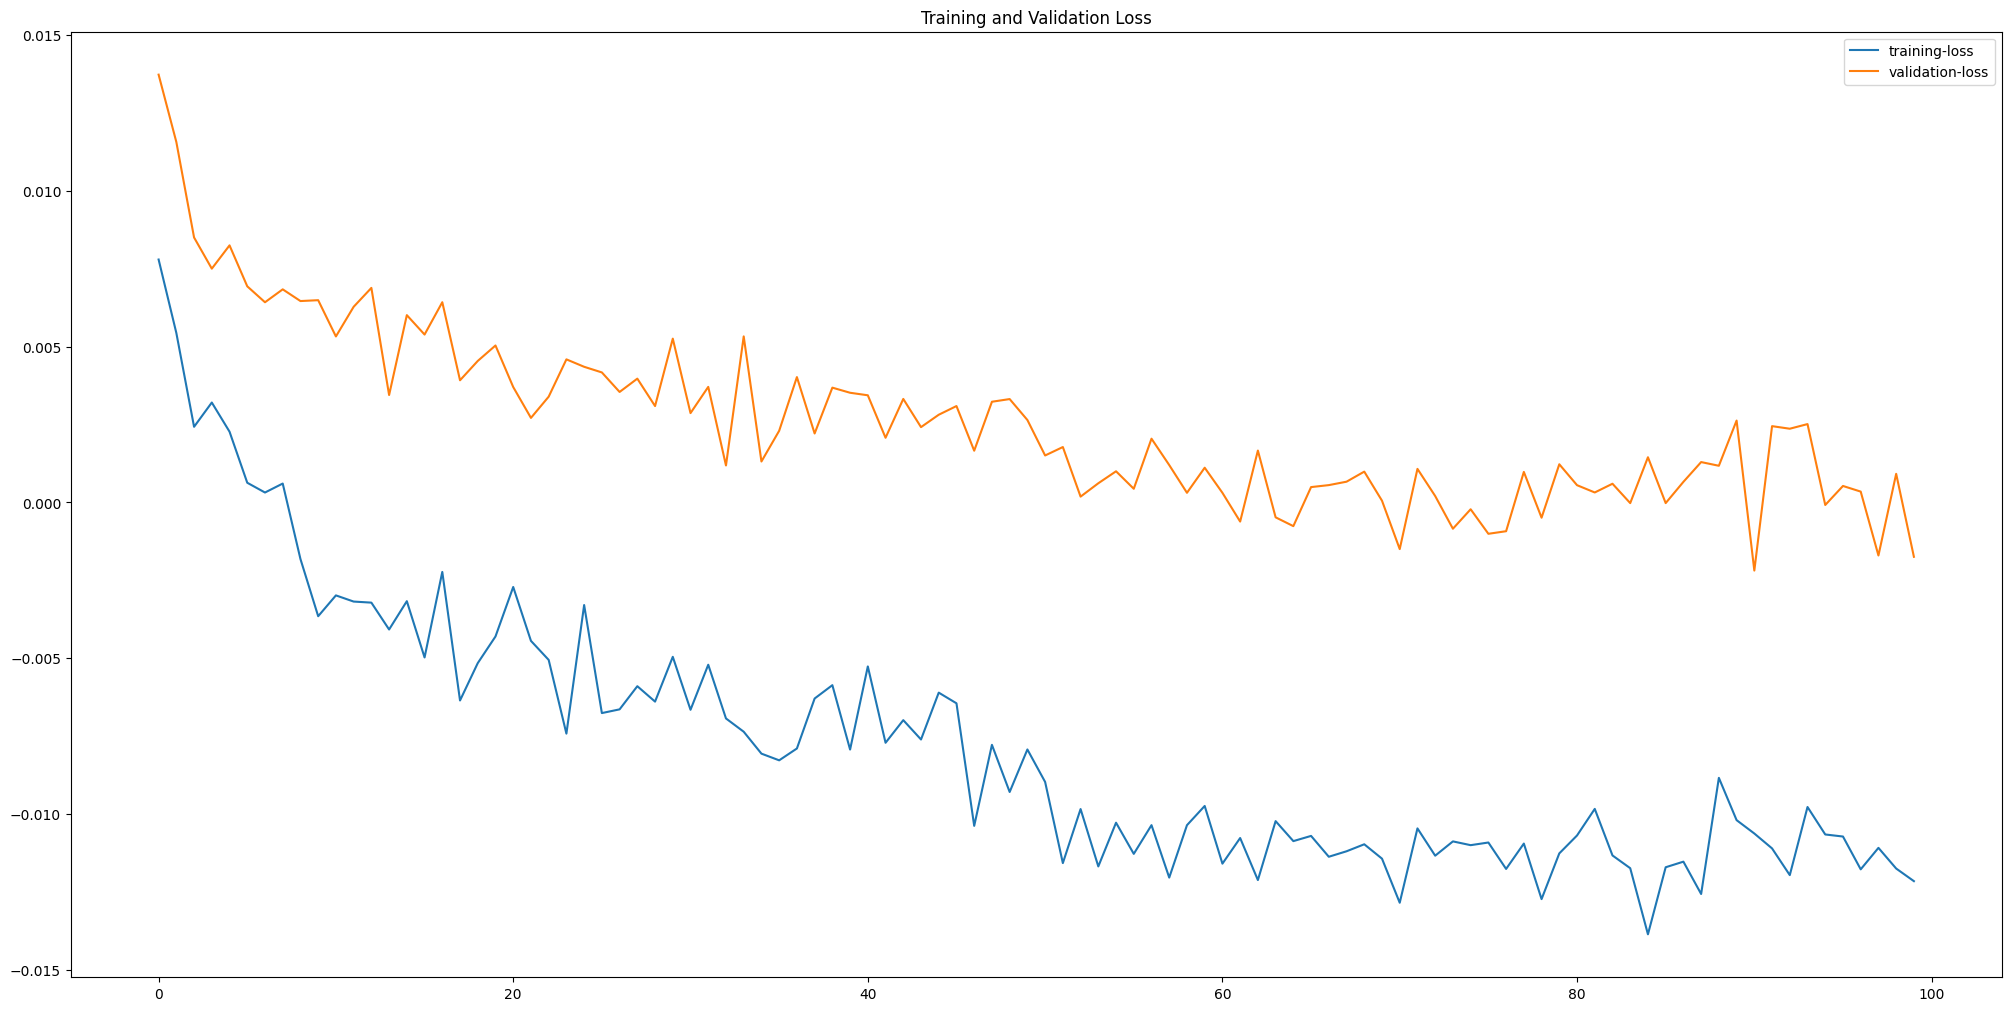

In [104]:
lvi = torch.tensor(lossi).view(-1,1000).mean(1)
lvp = torch.tensor(lossv).view(-1,1000).mean(1)


fig, ax = plt.subplots(figsize=(20, 10), layout='constrained')
ax.plot(lvi, label='training-loss')  
ax.plot(lvp, label='validation-loss')  
ax.set_title("Training and Validation Loss") 
ax.legend();  # Add a legend.

In [105]:
for layer in model.layers:
    layer.training = False
    


In [106]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))
    

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 2, 40)
Linear : (32, 2, 24)
BatchNorm1d : (32, 2, 24)
Tanh : (32, 2, 24)
FlattenConsecutive : (32, 48)
Linear : (32, 12)
BatchNorm1d : (32, 12)
Tanh : (32, 12)
Linear : (32, 3)


Text(0.5, 1.0, 'gradient distribution')

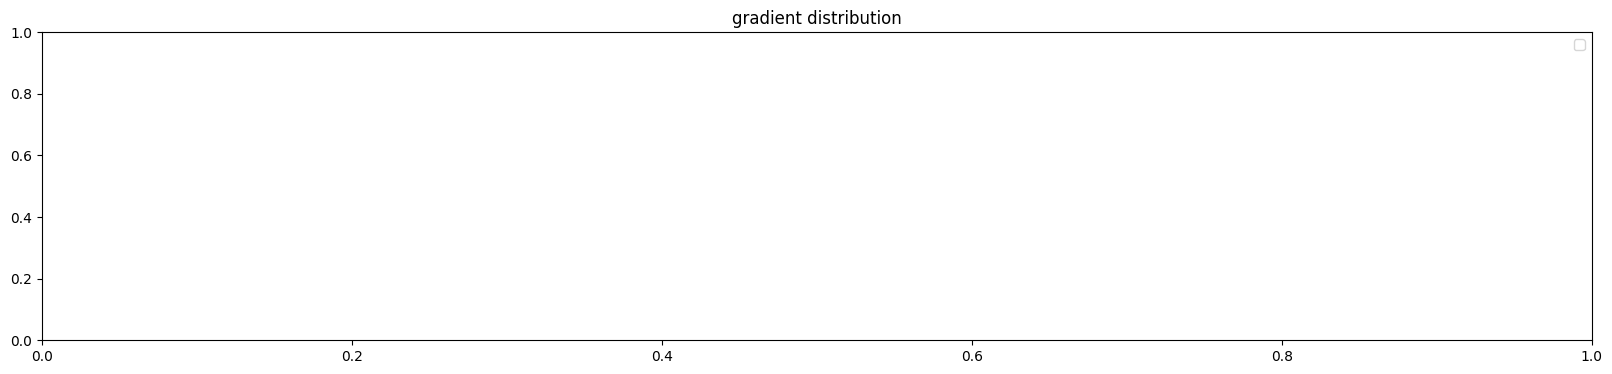

In [107]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    if t != None:
      print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
      hy, hx = torch.histogram(t, density=True)
      plt.plot(hx[:-1].detach(), hy.detach())
      legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


layer 4 (      Tanh): mean -0.02, std 0.68, saturated: 6.84%
layer 8 (      Tanh): mean +0.05, std 0.62, saturated: 5.21%


Text(0.5, 1.0, 'activation distribution')

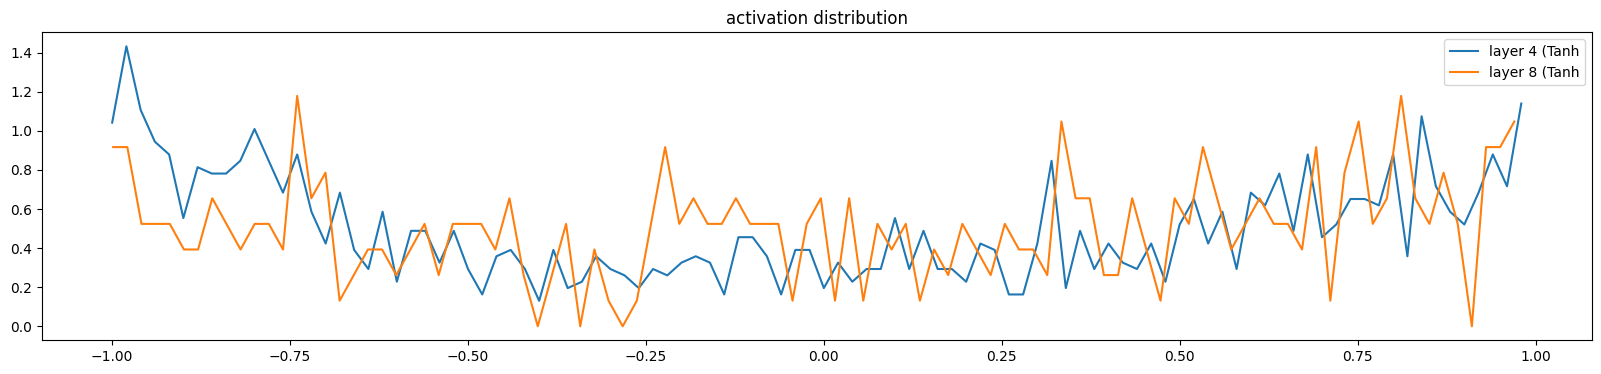

In [108]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh) or isinstance(layer, Softmax):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


weight (18283, 10) | mean +0.000000 | std 1.009261e-04 | grad:data ratio 1.012684e-04
weight   (40, 24) | mean -0.000113 | std 7.608792e-03 | grad:data ratio 3.184806e-02
weight   (48, 12) | mean +0.000175 | std 9.135492e-03 | grad:data ratio 3.362391e-02
weight    (12, 3) | mean +0.000000 | std 3.492855e-02 | grad:data ratio 9.463669e-02


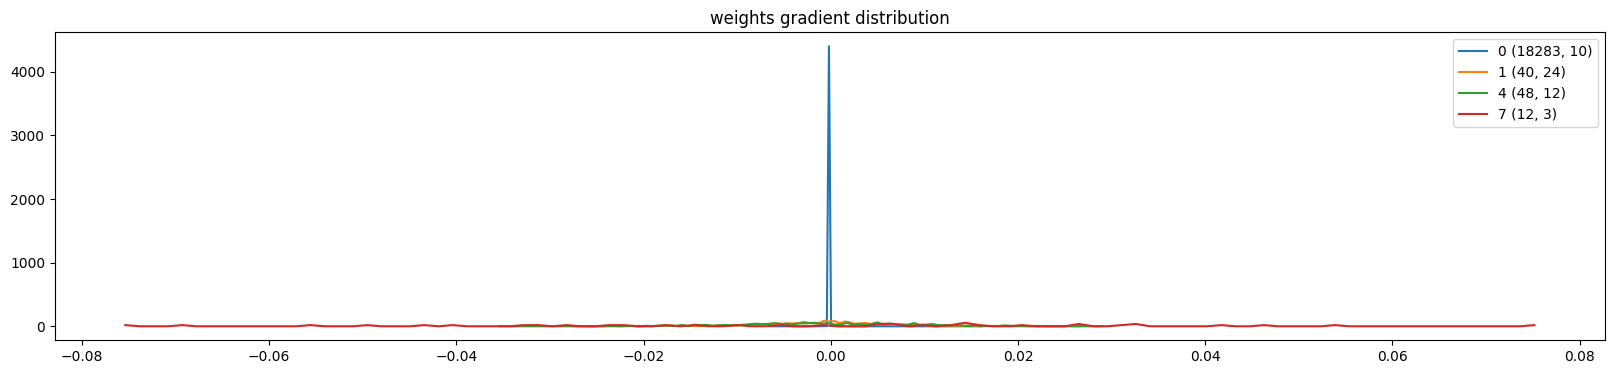

In [109]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

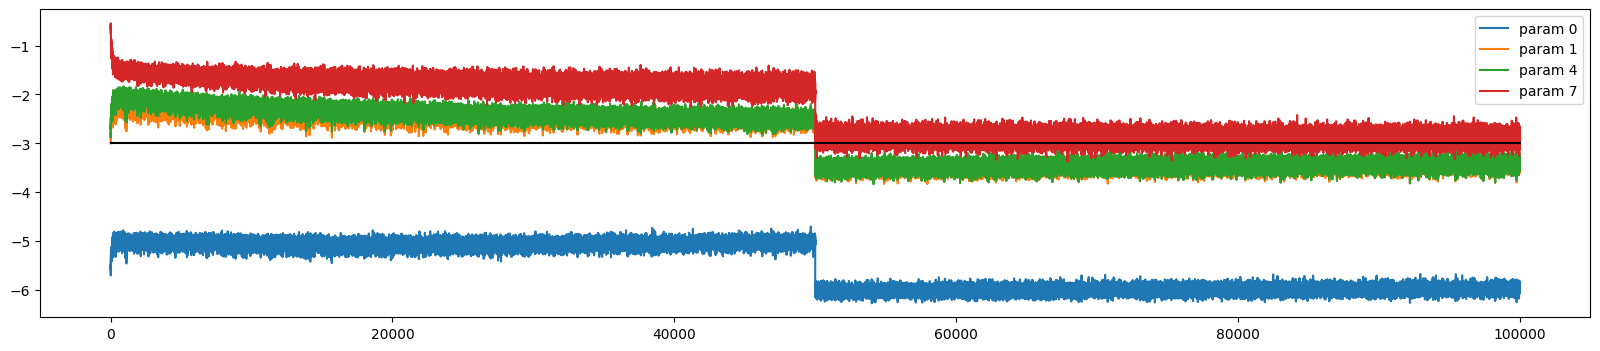

In [110]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [111]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 0.9737085103988647
val 1.0015180110931396
test 0.9801344275474548


In [112]:

@torch.no_grad()
def test_dataset(split):
  X,Y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]  

  correct = 0
  total = 0
  for i in range(X.shape[0] // batch_size):
    ix = torch.arange(i*batch_size, (i+1)*batch_size)
    Xc, Yc = X[ix], Y[ix] # batch X,Y

    logits = model(Xc)
    probs = F.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)

    target = []
    for t in preds.tolist():
      target.append(to_categorical(t, num_classes=readable_labels_size))
    target = torch.stack(target)

    for x,y,p,t in zip(Xc, Yc, probs, target):
      act = readable_labels[itol[ctoi(y)]]
      pred = readable_labels[itol[ctoi(t)]]
      if act == pred:
        correct += 1
      total += 1
      # if total % 100 == 0:
      #   print(' '.join(itos[ix.item()] for ix in x), '\n\t---> Actual:', act, '---> Predicted:', pred, f' probabaility : {torch.max(p).item()*100:.2f}%',  )
  return correct, total

correct,total = test_dataset('train')
print(f'[TRAIN] Correct Sentiment: {correct} out of {total}, Accuracy : {correct/total * 100:.2f}%')

correct,total = test_dataset('val')
print(f'[VAL] Correct Sentiment: {correct} out of {total}, Accuracy : {correct/total * 100:.2f}%')

correct,total = test_dataset('test')
print(f'[TEST] Correct Sentiment: {correct} out of {total}, Accuracy : {correct/total * 100:.2f}%')


[TRAIN] Correct Sentiment: 78992 out of 163552, Accuracy : 48.30%
[VAL] Correct Sentiment: 9982 out of 21248, Accuracy : 46.98%
[TEST] Correct Sentiment: 20001 out of 42400, Accuracy : 47.17%
